Load Input Image

In [1]:
# Input picture.
# Choose 'lily.png'
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


ModuleNotFoundError: No module named 'google'

Image Processing Functions. You do not need to edit this block.

In [1]:
from __future__ import division
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
import numpy as np
import scipy as sp
from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm


"""Helper image-processing code."""
def image_to_matrix(image_file, grays=False):
    """
    Convert .png image to matrix
    of values.
    
    params:
    image_file = str
    grays = Boolean
    
    returns:
    img = (color) np.ndarray[np.ndarray[np.ndarray[float]]] 
    or (grayscale) np.ndarray[np.ndarray[float]]
    """
    img = image.imread(image_file)
    # in case of transparency values
    if(len(img.shape) == 3 and img.shape[2] > 3):
        height, width, depth = img.shape
        new_img = np.zeros([height, width, 3])
        for r in range(height):
            for c in range(width):
                new_img[r,c,:] = img[r,c,0:3]
        img = np.copy(new_img)
    if(grays and len(img.shape) == 3):
        height, width = img.shape[0:2]
        new_img = np.zeros([height, width])
        for r in range(height):
            for c in range(width):
                new_img[r,c] = img[r,c,0]
        img = new_img
    # clean up zeros
    if(len(img.shape) == 2):
        zeros = np.where(img == 0)[0]
        img[zeros] += 1e-7
    return img

def matrix_to_image(image_matrix, image_file):
    """
    Convert matrix of color/grayscale 
    values  to .png image
    and save to file.
    
    params:
    image_matrix = (color) numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] or (grayscale) numpy.ndarray[numpy.ndarray[float]]
    image_file = str
    """
    # provide cmap to grayscale images
    cMap = None
    if(len(image_matrix.shape) < 3):
        cMap = cm.Greys_r
    
    image.imsave(image_file, image_matrix, cmap=cMap)
    #image.imsave(image_file, image_matrix, cmap=cm.Greys_r)

    # If using Google Colab
    #files.download(image_file)
    
def image_width(image_matrix):
    if(len(image_matrix.shape) == 3):
        height, width, depth = image_matrix.shape
    else:
        height, width = image_matrix.shape
    return width
    
def flatten_image_matrix(image_matrix):
    """
    Flatten image matrix from 
    Height by Width by Depth
    to (Height*Width) by Depth
    matrix.
    
    params:
    image_matrix = (color) numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] or (grayscale) numpy.ndarray[numpy.ndarray[float]]
    
    returns:
    flattened_values = (color) numpy.ndarray[numpy.ndarray[float]] or (grayscale) numpy.ndarray[float]    
    """
    if(len(image_matrix.shape) == 3):
        height, width, depth = image_matrix.shape
    else:
        height, width = image_matrix.shape
        depth = 1
    flattened_values = np.zeros([height*width,depth])
    for i, r in enumerate(image_matrix):
        for j, c in enumerate(r):
            flattened_values[i*width+j,:] = c
    return flattened_values

def unflatten_image_matrix(image_matrix, width):
    """
    Unflatten image matrix from
    (Height*Width) by Depth to
    Height by Width by Depth matrix.
    
    params:
    image_matrix = (color) numpy.ndarray[numpy.ndarray[float]] or (grayscale) numpy.ndarray[float]
    width = int
    
    returns:
    unflattened_values = (color) numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] or (grayscale) numpy.ndarray[numpy.ndarray[float]]
    """
    heightWidth = image_matrix.shape[0]
    height = int(heightWidth / width)
    if(len(image_matrix.shape) > 1):
        depth = image_matrix.shape[-1]
        unflattened_values = np.zeros([height, width, depth])
        for i in range(height):
            for j in range(width):
                unflattened_values[i,j,:] = image_matrix[i*width+j,:]
    else:
        depth = 1
        unflattened_values = np.zeros([height, width])
        for i in range(height):
            for j in range(width):
                unflattened_values[i,j] = image_matrix[i*width+j]
    return unflattened_values

def image_difference(image_values_1, image_values_2):
    """
    Calculate the total difference 
    in values between two images.
    Assumes that both images have same
    shape.
    
    params:
    image_values_1 = (color) numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] or (grayscale) numpy.ndarray[numpy.ndarray[float]]
    image_values_2 = (color) numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] or (grayscale) numpy.ndarray[numpy.ndarray[float]]
    
    returns:
    dist = int
    """
    flat_vals_1 = flatten_image_matrix(image_values_1)
    flat_vals_2 = flatten_image_matrix(image_values_2)
    N, depth = flat_vals_1.shape
    dist = 0.
    point_thresh = 0.005
    for i in range(N):
        if(depth > 1):
            new_dist = sum(abs(flat_vals_1[i] - flat_vals_2[i]))
            if(new_dist > depth * point_thresh):
                dist += new_dist
        else:
            new_dist = abs(flat_vals_1[i] - flat_vals_2[i])
            if(new_dist > point_thresh):
                dist += new_dist
    return dist



Functions you need to edit for Homework 3

In [15]:
from random import randint
from math import sqrt
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

def k_means_cluster(image_values, k=3):
    """
    Separate the provided RGB values into
    k separate clusters using the k-means algorithm,
    then return an updated version of the image
    with the original values replaced with
    the corresponding cluster values.
    
    params:
    image_values = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]
    k = int
    initial_means = numpy.ndarray[numpy.ndarray[float]] or None
    
    returns:
    updated_image_values = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]
    """
    def distance_point_mean(pix,clustMean):
        d = sqrt( (pix[0]-clustMean[0])*(pix[0]-clustMean[0]) + (pix[1]-clustMean[1])*(pix[1]-clustMean[1]) + (pix[2]-clustMean[2])*(pix[2]-clustMean[2]) )
        
        return d
    
    
    # Flatten the image matrix
    imHeight,imWidth,imDep = np.shape(image_values)
    flat_image = flatten_image_matrix(image_values)
    numPix, rgbdim = np.shape(flat_image)    
    updated_image_values = np.copy(flat_image)
    image_val = np.copy(updated_image_values)

    #####################################################
    # Select initial cluster centers
    #    Note 1: you can modify the function to be given 
    #            the initial means as an input.
    #    Note 2: I've included a line of code that sets all 
    #            of the initial means to zero. I don't 
    #            suggest you keep it that way.
    #####################################################
    
    # initial centroid locations
    # this rgb is from 0 to 1
    cluster_means = []
    for i in range(k):
        cluster_means.append([randint(0,1), randint(0,1), randint(0,1)])   
    
    #####################################################
    # Implement k-means
    #####################################################
    
    
    # this 1D array will have eaxh pixel assigned to a cluster, will use after algorithm
    cluster_assignments = []
    
    covergence = False
    iteration = 0
    while not covergence and iteration < 30:

        # E Step: Assign each pixel to a centroid cluster
        cluster_assignments = []
        
        for pixel in updated_image_values:
            # find the centriod cluster that is closest to the pixel
            min_distance = 1000
            assignment = 0

            for index in range(k):
                distance = distance_point_mean(pixel, cluster_means[index])
                if distance < min_distance:
                    min_distance = distance
                    assignment = index
            
            cluster_assignments.append(assignment)
    
        # keep old mean of clusters before finding new means
        old_mean_clusters = cluster_means.copy()

        # M step: Find new means of clusters
        for cluster in range(k):
            
            rgb = [0,0,0]
            assignment_counter = 0
            pixel_index = 0

            for assignment in cluster_assignments:
                if assignment == cluster:
                    # add the rbg value of the pixel assigned to that cluster
                    rgb[0] += updated_image_values[pixel_index][0]
                    rgb[1] += updated_image_values[pixel_index][1]
                    rgb[2] += updated_image_values[pixel_index][2]
                    assignment_counter += 1

                pixel_index += 1

            if assignment_counter != 0:
                cluster_means[cluster] = [sum / assignment_counter for sum in rgb]
        
        # stop criteria
        iteration += 1
        covergence = True
        for i in range(k):
            for j in range(3):
                if cluster_means[i][j] != old_mean_clusters[i][j]:
                    covergence = False

    
    print("iteration #: ", iteration)
    print()
    
    # now out of loop, will need to update pixels to their new cluster rgb values
    for i in range(len(updated_image_values)):
        cluster = cluster_assignments[i]
        updated_image_values[i] = cluster_means[cluster]
     
    # Unflatten the image matrix with the updated values. Return the unflattened matrix.
    updated_image_values_sqr = unflatten_image_matrix(updated_image_values,imWidth)

    return updated_image_values_sqr
    
def k_means_test():
    """
    Testing your implementation
    of k-means on the segmented
    reference images.
    """
    
    # Make sure you have loaded the input image (first cell of code)
    # Identify the location of the input image. 
    # Load the image in as a matrix.
    image_dir = 'images/'
    image_name = 'lily.png'
    image_name = 'Blizard'
    image_values = image_to_matrix('images/blizard.png')

    # Define how many (k) clusters you want.
    # For debugging, I suggest you use k == 2. 
    #k = 2
    # k = 3
    k = 4
    
    # Call k-means.
    updated_values = k_means_cluster(image_values, k)
    print(updated_values.shape)

    # Convert the output pixels from matrix to image. Save the output image.
    ref_image = 'k%d_%s'%(k, image_name)
    matrix_to_image(updated_values, ref_image)
    
    

k_means_test()


iteration #:  30

(640, 400, 3)


ValueError: Floating point image RGB values must be in the 0..1 range.

In [2]:
from random import randint
from math import sqrt
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

image_dir = 'images/'
image_name = 'lily.png'
image_values = image_to_matrix(image_dir + image_name)

# Flatten the image matrix
imHeight,imWidth,imDep = np.shape(image_values)
flat_image = flatten_image_matrix(image_values)
numPix, rgbdim = np.shape(flat_image)    
updated_image_values = np.copy(flat_image)

'\nfig = plt.figure()\nax = Axes3D(fig)\nax.scatter(updated_image_values[:,0], updated_image_values[:,1], updated_image_values[:,2])\nplt.show()\n'

Text(0.5, 0, 'Blue')

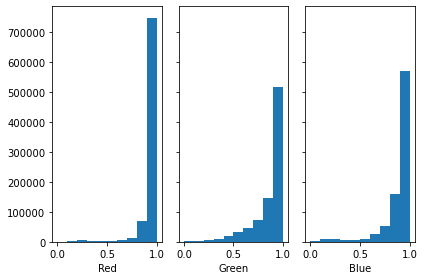

In [25]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True)
r = updated_image_values[:,0]
g = updated_image_values[:,1]
b = updated_image_values[:,2]

ax[0].hist(r)
ax[0].set_xlabel('Red')
ax[1].hist(g)
ax[1].set_xlabel('Green')
ax[2].hist(b)
ax[2].set_xlabel('Blue')

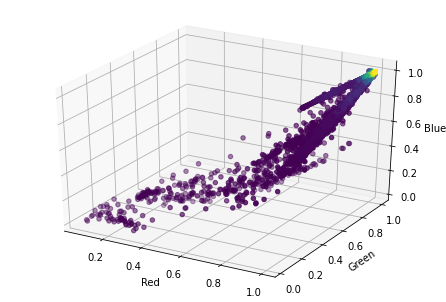

In [14]:
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
df = pd.DataFrame(data=updated_image_values, columns=["Red", "Green", "Blue"])

df_1000 = df.sample(n=10000)
r = df_1000["Red"]
g = df_1000["Green"]
b = df_1000["Blue"]

fig = plt.figure()
ax = Axes3D(fig)
rgb = np.vstack([r,g,b])
z= stats.gaussian_kde(rgb)(rgb)
ax.scatter(r, g, b, c=z)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()
